# Creating a raster mosaic

Quite often you need to merge multiple raster files together and create a `raster mosaic`. This can be done easily with the `merge()` -function in Rasterio.

Here, we will create a mosaic based on 2X2m resolution DEM files (altogether 12 files) covering the Helsinki Metropolitan region. If you have not downloaded the DEM files yet, you can do that by running the script from download-data -section of the tutorial.

As there are many `tif` files in our folder, it is not really pracical to start listing them manually. Luckily, we have a module and function called `glob` that can be used to create a list of those files that we are interested in based on search criteria.

Let's start by:
   
  - Importing required modules
  - Finding all `tif` files from the folder where the file starts with `L` -letter.


## Creating a raster mosaic with rioxarray

Read elevation data from S3 bucket for Kilimanjaro region in Africa.

In [58]:
import xarray as xr
import os
import rioxarray as rxr
from rioxarray.merge import merge_datasets

# S3 bucket containing the data
bucket = "https://a3s.fi/swift/v1/AUTH_0914d8aff9684df589041a759b549fc2/PythonGIS"

# Generate urls for the elevation files
urls = [
    os.path.join(bucket, "elevation/kilimanjaro/ASTGTMV003_S03E036_dem.tif"),
    os.path.join(bucket, "elevation/kilimanjaro/ASTGTMV003_S03E037_dem.tif"),
    os.path.join(bucket, "elevation/kilimanjaro/ASTGTMV003_S04E036_dem.tif"),
    os.path.join(bucket, "elevation/kilimanjaro/ASTGTMV003_S04E037_dem.tif"),
]

# Read the files
datasets = [
    xr.open_dataset(url, engine="rasterio").squeeze("band", drop=True) for url in urls
]

Investigate how our data looks like:

In [57]:
datasets[0]

<xarray.Dataset>
Dimensions:      (x: 3601, y: 3601)
Coordinates:
  * x            (x) float64 36.0 36.0 36.0 36.0 36.0 ... 37.0 37.0 37.0 37.0
  * y            (y) float64 -2.0 -2.0 -2.001 -2.001 ... -2.999 -2.999 -3.0 -3.0
    spatial_ref  int64 ...
Data variables:
    band_data    (y, x) float32 ...

Visualize the tiles to see how they look like separately:

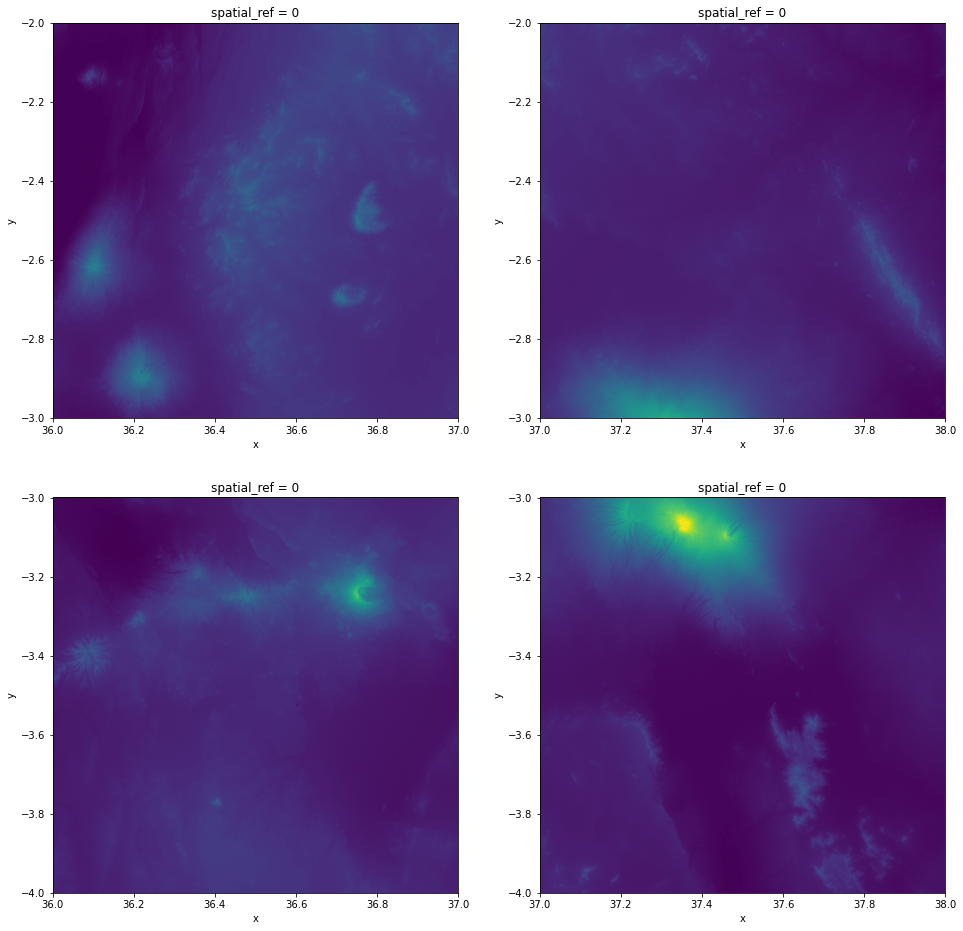

In [111]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(16, 16))

# Plot the tiles to see how they look separately
datasets[0]["band_data"].plot(ax=axes[0][0], vmax=5900, add_colorbar=False)
datasets[1]["band_data"].plot(ax=axes[0][1], vmax=5900, add_colorbar=False)
datasets[2]["band_data"].plot(ax=axes[1][0], vmax=5900, add_colorbar=False)
datasets[3]["band_data"].plot(ax=axes[1][1], vmax=5900, add_colorbar=False)

Create a raster mosaic by merging these Datasets:

In [46]:
# Create a mosaic out of the tiles
mosaic = merge_datasets(datasets)

Rename the data variable to more intuitive one:

In [51]:
# Add a more intuitive name for the data variable
mosaic = mosaic.rename({"band_data": "elevation"})

Plot the end result where the tiles have been merged:

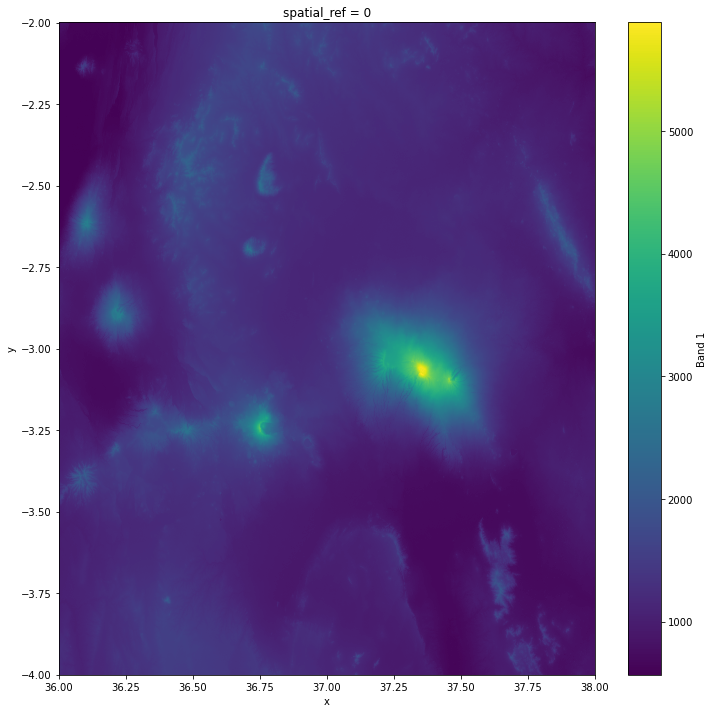

In [52]:
# Plot the mosaic
mosaic["elevation"].plot(figsize=(12, 12))

## Clipping raster

Create a GeoDataFrame with bounding box that we can use for clipping the raster:

In [72]:
import geopandas as gpd
from shapely.geometry import box

# Bounding box coordinates
minx = 37.1
miny = -3.3
maxx = 37.6
maxy = -2.85

# Create a GeoDataFrame that will be used to clip the raster
geom = box(minx, miny, maxx, maxy)
clipping_gdf = gpd.GeoDataFrame({"geometry": [geom]}, index=[0], crs="epsg:4326")

# Explore the extent on a map
clipping_gdf.explore()

Clip the mosaic with GeoDataFrame:

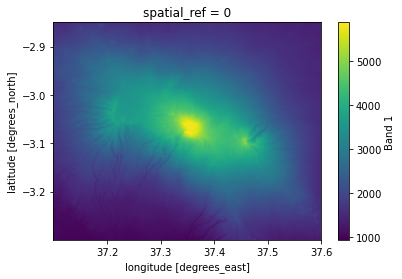

In [101]:
# Clip the Mosaic with GeoDataFrame and specify CRS
kilimanjaro = mosaic.rio.clip(clipping_gdf.geometry, crs=mosaic.elevation.rio.crs)
kilimanjaro["elevation"].plot()

In [105]:
kilimanjaro

<xarray.Dataset>
Dimensions:      (y: 1620, x: 1800)
Coordinates:
  * y            (y) float64 -2.85 -2.85 -2.851 -2.851 ... -3.299 -3.299 -3.3
  * x            (x) float64 37.1 37.1 37.1 37.1 37.1 ... 37.6 37.6 37.6 37.6
    spatial_ref  int64 0
Data variables:
    elevation    (y, x) float32 1.581e+03 1.581e+03 ... 1.295e+03 1.294e+03

Save the raster to a GeoTIFF file:

In [110]:
# Save file to GeoTIFF
kilimanjaro.rio.to_raster("data/kilimanjaro.tif", compress="LZMA", tiled=True)

### Working with rasterio - Remove from book

In [1]:
import rasterio
from rasterio.merge import merge
from rasterio.plot import show
import glob
import os

%matplotlib inline

# File and folder paths
dirpath = "L5_data"
out_fp = os.path.join(dirpath, "Helsinki_DEM2x2m_Mosaic.tif")

# Make a search criteria to select the DEM files
search_criteria = "L*.tif"
q = os.path.join(dirpath, search_criteria)
print(q)

L5_data\L*.tif


Now we can see that we have a search criteria (variable `q`) that we can pass to `glob` -function.

- List all digital elevation files with glob() -function:

In [2]:
# glob function can be used to list files from a directory with specific criteria
dem_fps = glob.glob(q)

# Files that were found:
dem_fps

['L5_data\\L4133A.tif',
 'L5_data\\L4133B.tif',
 'L5_data\\L4133C.tif',
 'L5_data\\L4133D.tif',
 'L5_data\\L4133E.tif',
 'L5_data\\L4133F.tif',
 'L5_data\\L4134A.tif',
 'L5_data\\L4134B.tif',
 'L5_data\\L4134C.tif',
 'L5_data\\L4134D.tif',
 'L5_data\\L4134E.tif',
 'L5_data\\L4134F.tif']

Great! Now we have all those 12 files in a list and we can start to make a mosaic out of them.

- Let's first create a list for the source raster datafiles (in read mode) with rasterio that will be used to create the mosaic:


In [3]:
# List for the source files
src_files_to_mosaic = []

# Iterate over raster files and add them to source -list in 'read mode'
for fp in dem_fps:
    src = rasterio.open(fp)
    src_files_to_mosaic.append(src)

src_files_to_mosaic

[<open DatasetReader name='L5_data\L4133A.tif' mode='r'>,
 <open DatasetReader name='L5_data\L4133B.tif' mode='r'>,
 <open DatasetReader name='L5_data\L4133C.tif' mode='r'>,
 <open DatasetReader name='L5_data\L4133D.tif' mode='r'>,
 <open DatasetReader name='L5_data\L4133E.tif' mode='r'>,
 <open DatasetReader name='L5_data\L4133F.tif' mode='r'>,
 <open DatasetReader name='L5_data\L4134A.tif' mode='r'>,
 <open DatasetReader name='L5_data\L4134B.tif' mode='r'>,
 <open DatasetReader name='L5_data\L4134C.tif' mode='r'>,
 <open DatasetReader name='L5_data\L4134D.tif' mode='r'>,
 <open DatasetReader name='L5_data\L4134E.tif' mode='r'>,
 <open DatasetReader name='L5_data\L4134F.tif' mode='r'>]

As we can see, now the list contains all those files as raster objects in read mode (´mode='r'´).

- Let's plot a few of them next to each other to see how they look like:

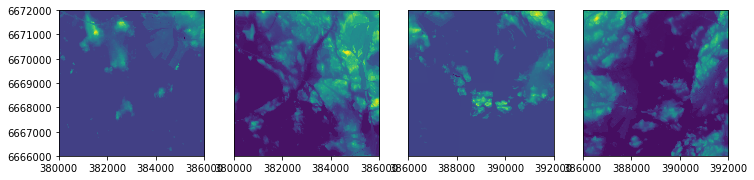

In [4]:
import matplotlib.pyplot as plt

%matplotlib inline

# Create 4 plots next to each other
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, nrows=1, figsize=(12, 4))

# Plot first four files
show(src_files_to_mosaic[0], ax=ax1)
show(src_files_to_mosaic[1], ax=ax2)
show(src_files_to_mosaic[2], ax=ax3)
show(src_files_to_mosaic[3], ax=ax4)

# Do not show y-ticks values in last three axis
for ax in [ax2, ax3, ax4]:
    ax.yaxis.set_visible(False)

As we can see we have multiple separate raster files that are actually located next to each other. Hence, we want to put them together into a single raster file that can by done by creating a raster mosaic.

- Now as we have placed the individual raster files in read -mode into the `source_files_to_mosaic` -list, it is really easy to merge those together and create a mosaic with rasterio's `merge` function:

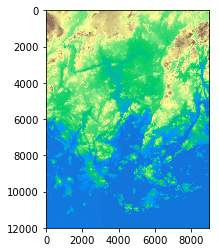

In [5]:
# Merge function returns a single mosaic array and the transformation info
mosaic, out_trans = merge(src_files_to_mosaic)

# Plot the result
show(mosaic, cmap="terrain")

Great, it looks correct! Now we are ready to save our mosaic to disk.

- Let's first update the metadata with our new dimensions, transform and CRS:

In [6]:
# Copy the metadata
out_meta = src.meta.copy()

# Update the metadata
out_meta.update(
    {
        "driver": "GTiff",
        "height": mosaic.shape[1],
        "width": mosaic.shape[2],
        "transform": out_trans,
        "crs": "+proj=utm +zone=35 +ellps=GRS80 +units=m +no_defs ",
    }
)

- Finally we can write our mosaic to our computer:

In [7]:
# Write the mosaic raster to disk
with rasterio.open(out_fp, "w", **out_meta) as dest:
    dest.write(mosaic)

That's it! Easy!